# Baseline models

#### In this notebook we will use our functions to import and clean the data to get some first models, that we can use as baselines to further improve

In [ ]:
# import required packages
pip install -e python-package/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from src.data.make_dataset import merge_data 
from src.features.build_features import features,split_data, drop_correlated_features
from src.features.anomaly_dataset import subset_without_anomalies
pd.options.display.max_columns =70


# I. Import whole dataset

#### At first we use our self defined function merge data to import and concatenate our train and test set, so we can use the same preprocessing steps on all our data together.

In [2]:
def merge_data(train_values, train_target, test_values):
    """
    Function to import all data and concatenate it into one dataframe.
    :return: one dataframe only with train and test features together with train labels
    """

    data = train_values.join(train_target)

    return pd.concat([data, test_values])

# merge the dataset at a whole (train, test & target data all together)
train_values = pd.read_csv('Train_Values.csv', index_col='building_id')
train_target = pd.read_csv('Train_Labels.csv', index_col='building_id')
test_values = pd.read_csv('Test_Values.csv', index_col='building_id')

df=merge_data(train_values, train_target, test_values)
df=df.reset_index()
display(df)

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0            802906               6             487           12198   
1             28830               8             900            2812   
2             94947              21             363            8973   
3            590882              22             418           10694   
4            201944              11             131            1488   
...             ...             ...             ...             ...   
347464       310028               4             605            3623   
347465       663567              10            1407           11907   
347466      1049160              22            1136            7712   
347467       442785               6            1041             912   
347468       501372              26              36            6436   

        count_floors_pre_eq  age  area_percentage  height_percentage  \
0                         2   30                6                  5   
1                         2   10                8                  7   
2                         2   10                5                  5   
3                         2   10                6                  5   
4                         3   30                8                  9   
...                     ...  ...              ...                ...   
347464                    3   70               20                  6   
347465                    3   25                6                  7   
347466                    1   50                3                  3   
347467                    2    5                9                  5   
347468                    2   10               11                  4   

       land_surface_condition foundation_type roof_type ground_floor_type  \
0                           t               r         n                 f   
1                           o               r         n                 x   
2                           t               r         n                 f   
3                           t               r         n                 f   
4                           t               r         n                 f   
...                       ...             ...       ...               ...   
347464                      t               r         q                 f   
347465                      n               r         n                 f   
347466                      t               r         n                 f   
347467                      t               r         n                 f   
347468                      t               r         q                 v   

       other_floor_type position plan_configuration  \
0                     q        t                  d   
1                     q        s                  d   
2                     x        t                  d   
3                     x        s                  d   
4                     x        s                  d   
...                 ...      ...                ...   
347464                q        t                  d   
347465                q        s                  d   
347466                j        s                  d   
347467                q        s                  d   
347468                q        s                  d   

        has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                                  1                                    1   
1                                  0                                    1   
2                                  0                                    1   
3                                  0                                    1   
4                                  1                                    0   
...                              ...                                  ...   
347464                             0                                    1   
347465                             1                                    1   
347466     

# II. Preprocess dataset

#### We will now use our self-defined function features to take some first preprocessing steps including one-hot-encoding and scaling our features

In [3]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np
import pandas as pd

def features(df):
    """
    Function to preprocess dataframe.
    :param df: raw dataframe, type: pd.DataFrame()
    :return: preprocessed dataframe with OneHotEncoder, MinMaxScaler
    """

    # list all categorical features that we want to encode using OneHotEncoder
    categorical_features = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
                            'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
    encoder = OneHotEncoder()
    encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features]).toarray(),
                           columns=encoder.get_feature_names(categorical_features))
    df = df.drop(columns=categorical_features).join(encoded)

    # list all numerical features that we want to re-scale
    numeric_features = ['count_floors_pre_eq', 'count_families']
    df[numeric_features] = MinMaxScaler().fit_transform(df[numeric_features])

    return df

# apply features function where encoding and scaling features from above happens
df=features(df)

In [4]:
display(df)

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0            802906               6             487           12198   
1             28830               8             900            2812   
2             94947              21             363            8973   
3            590882              22             418           10694   
4            201944              11             131            1488   
...             ...             ...             ...             ...   
347464       310028               4             605            3623   
347465       663567              10            1407           11907   
347466      1049160              22            1136            7712   
347467       442785               6            1041             912   
347468       501372              26              36            6436   

        count_floors_pre_eq  age  area_percentage  height_percentage  \
0                     0.125   30                6                  5   
1                     0.125   10                8                  7   
2                     0.125   10                5                  5   
3                     0.125   10                6                  5   
4                     0.250   30                8                  9   
...                     ...  ...              ...                ...   
347464                0.250   70               20                  6   
347465                0.250   25                6                  7   
347466                0.000   50                3                  3   
347467                0.125    5                9                  5   
347468                0.125   10               11                  4   

        has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                                  1                                    1   
1                                  0                                    1   
2                                  0                                    1   
3                                  0                                    1   
4                                  1                                    0   
...                              ...                                  ...   
347464                             0                                    1   
347465                             1                                    1   
347466                             0                                    1   
347467                             1                                    1   
347468                             0                                    0   

        has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   
...                               ...                                     ...   
347464                              0                                       0   
347465                              1                                       0   
347466                              0                                       0   
347467                              0                                       0   
347468                              0                                       0   

        has_superstructure_mud_mortar_brick  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
347464                                    0   
347465          

# III. Feature Selection

#### We will investigate the Correlations between our features and get rid of correlated features (correlatin > 0.8) to make our model more interpretable.

#### Additonally, we will perform an Isolation Forest in order to detect any outliert within our dataset so that we can compare our models based on datasets with(out) outliers as well.

<ipython-input-5-c3cbffdb7fa2>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


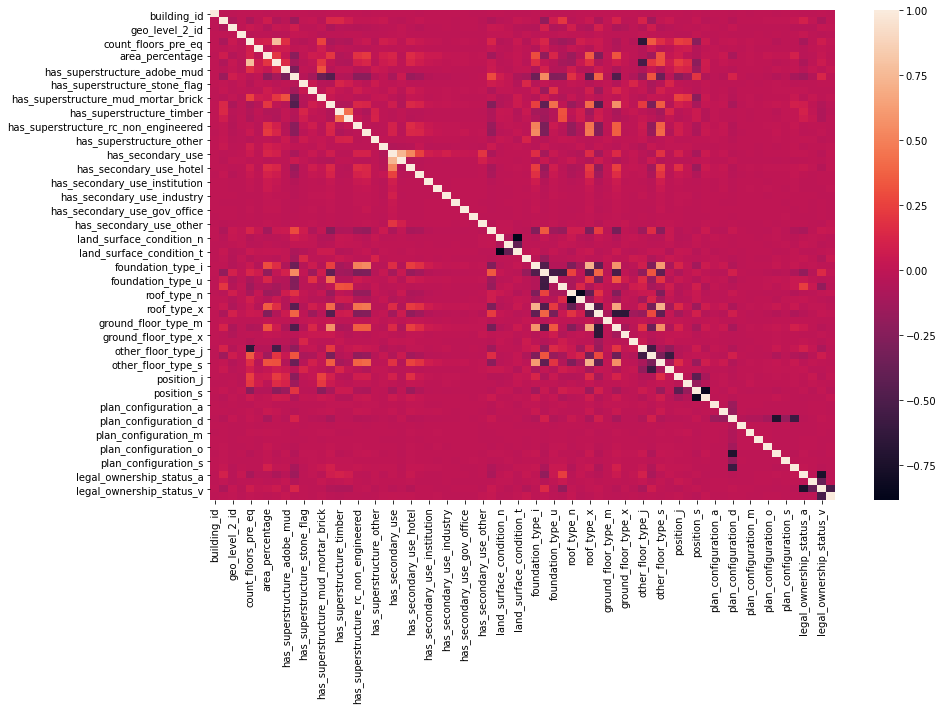

In [5]:
# investigate correlation heatmap
corrMatrix=df.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [6]:
def drop_correlated_features(df, thr=0.8):
    """
    Function to detect all correlated features
    :param df: general dataframe and threshold for the correlation param
    :return: dataframe without correlated features
    """
    correlated_features = set()
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > thr:
                print(
                    f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]), 2)}")
                colname = correlation_matrix.columns[j]
                correlated_features.add(colname)
    print(f"Drop the following features: {correlated_features}")
    # drop correlated features
    df = df.drop(columns=correlated_features)

    return df

# print all correlated features and drop them from the dataset
df=drop_correlated_features(df)

The following features are correlated: land_surface_condition_t and land_surface_condition_n. Correlation = 0.88
The following features are correlated: roof_type_q and roof_type_n. Correlation = 0.85
The following features are correlated: position_t and position_s. Correlation = 0.83
Drop the following features: {'roof_type_n', 'land_surface_condition_n', 'position_s'}


In [7]:
#scale geo_features for logistic regression and runtime
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id','age','area_percentage','height_percentage']
scaler = MinMaxScaler()
df[geo_features] = scaler.fit_transform(df[geo_features])
df

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0            802906        0.200000        0.341275        0.970637   
1             28830        0.266667        0.630694        0.223761   
2             94947        0.700000        0.254380        0.714013   
3            590882        0.733333        0.292922        0.850959   
4            201944        0.366667        0.091801        0.118405   
...             ...             ...             ...             ...   
347464       310028        0.133333        0.423966        0.288295   
347465       663567        0.333333        0.985985        0.947481   
347466      1049160        0.733333        0.796076        0.613671   
347467       442785        0.200000        0.729502        0.072571   
347468       501372        0.866667        0.025228        0.512135   

        count_floors_pre_eq       age  area_percentage  height_percentage  \
0                     0.125  0.030151         0.050505           0.100000   
1                     0.125  0.010050         0.070707           0.166667   
2                     0.125  0.010050         0.040404           0.100000   
3                     0.125  0.010050         0.050505           0.100000   
4                     0.250  0.030151         0.070707           0.233333   
...                     ...       ...              ...                ...   
347464                0.250  0.070352         0.191919           0.133333   
347465                0.250  0.025126         0.050505           0.166667   
347466                0.000  0.050251         0.020202           0.033333   
347467                0.125  0.005025         0.080808           0.100000   
347468                0.125  0.010050         0.101010           0.066667   

        has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                                  1                                    1   
1                                  0                                    1   
2                                  0                                    1   
3                                  0                                    1   
4                                  1                                    0   
...                              ...                                  ...   
347464                             0                                    1   
347465                             1                                    1   
347466                             0                                    1   
347467                             1                                    1   
347468                             0                                    0   

        has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   
...                               ...                                     ...   
347464                              0                                       0   
347465                              1                                       0   
347466                              0                                       0   
347467                              0                                       0   
347468                              0                                       0   

        has_superstructure_mud_mortar_brick  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
347

## Split dataset back into train and test set to perform outlier detection to generate an additional train set without outliert and an additonal rebalanced train set


#### We now use our self-defined function split_data to get our now preprocessed train and test set.

In [8]:
def split_data(df):
    """
    Function to split dataframe into train and test data.
    :param df: Preprocessed dataframe with added means of categorical features and dropped correlated features
    :return: tuple of preprocessed train data, labels of target data (train target) and preprocessed test data splitted
    """

    df = df.set_index('building_id')

    # split data back into train, label and test
    train_data = df.loc[np.invert(df.damage_grade.isna())]  # data where labels for damage grade are empty
    train_target = train_data['damage_grade']
    train_data = train_data.drop(columns='damage_grade')
    test_data = df.loc[df.damage_grade.isna()].drop(columns='damage_grade')

    return train_data, train_target, test_data

data_train, target_train, data_test = split_data(df)
data_train

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906             0.200000        0.341275        0.970637   
28830              0.266667        0.630694        0.223761   
94947              0.700000        0.254380        0.714013   
590882             0.733333        0.292922        0.850959   
201944             0.366667        0.091801        0.118405   
...                     ...             ...             ...   
688636             0.833333        0.935529        0.128989   
669485             0.566667        0.501051        0.163921   
602512             0.566667        0.035739        0.649558   
151409             0.866667        0.027330        0.147291   
747594             0.700000        0.006307        0.724198   

             count_floors_pre_eq       age  area_percentage  \
building_id                                                   
802906                     0.125  0.030151         0.050505   
28830                      0.125  0.010050         0.070707   
94947                      0.125  0.010050         0.040404   
590882                     0.125  0.010050         0.050505   
201944                     0.250  0.030151         0.070707   
...                          ...       ...              ...   
688636                     0.000  0.055276         0.050505   
669485                     0.125  0.000000         0.050505   
602512                     0.250  0.055276         0.050505   
151409                     0.125  0.010050         0.131313   
747594                     0.250  0.010050         0.060606   

             height_percentage  has_superstructure_adobe_mud  \
building_id                                                    
802906                0.100000                             1   
28830                 0.166667                             0   
94947                 0.100000                             0   
590882                0.100000                             0   
201944                0.233333                             1   
...                        ...                           ...   
688636                0.033333                             0   
669485                0.100000                             0   
602512                0.166667                             0   
151409                0.133333                             0   
747594                0.133333                             0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
802906                                         1   
28830                                          1   
94947                                          1   
590882                                         1   
201944                                         0   
...                                          ...   
688636                                         1   
669485                                         1   
602512                                         1   
151409                                         0   
747594                                         1   

             has_superstructure_stone_flag  \
building_id                                  
802906                                   0   
28830                                    0   
94947                                    0   
590882                                   0   
201944                                   0   
...                                    ...   
688636                                   0   
669485                                   0   
602512                                   0   
151409                                   0   
747594                                   0   

             has_superstructure_cement_mortar_stone  \
building_id                                           
802906                                            0   
28830                                             0   
94947                                       

### Create an additional training dataset that does not contain any outliers detected by the IsolationForest

In [9]:
data_train_outlier = data_train.copy()
target_train_outlier = target_train.copy()

In [11]:
from sklearn.ensemble import IsolationForest

#build model & add prediction (anomalies = -1/1) to dataframe
iForest = IsolationForest(random_state=42, max_samples = 1000, n_estimators = 150)
iForest.fit(data_train_outlier)
data_train_outlier['anomaly']=iForest.predict(data_train_outlier)
    
#merge columns to drop all rows with anomalies to avoid any mismatch
data_train_outlier = data_train_outlier.join(target_train_outlier, how = 'left', on='building_id')
    
#drop rows with anomalies/outliers
indexes_to_drop = data_train_outlier[data_train_outlier['anomaly']==-1].index
indexes_to_keep = set(range(data_train_outlier.shape[0])) - set(indexes_to_drop)
data_train_outlier = data_train_outlier.take(list(indexes_to_keep))

#drop anomaly column
data_train_outlier = data_train_outlier.drop(columns='anomaly')
    
#split datasets again into train- and target values
target_train_outlier = pd.DataFrame(data_train_outlier['damage_grade'])
data_train_outlier = data_train_outlier.drop(columns = 'damage_grade')

In [12]:
data_train_outlier

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906             0.200000        0.341275        0.970637   
28830              0.266667        0.630694        0.223761   
94947              0.700000        0.254380        0.714013   
590882             0.733333        0.292922        0.850959   
201944             0.366667        0.091801        0.118405   
...                     ...             ...             ...   
688636             0.833333        0.935529        0.128989   
669485             0.566667        0.501051        0.163921   
602512             0.566667        0.035739        0.649558   
151409             0.866667        0.027330        0.147291   
747594             0.700000        0.006307        0.724198   

             count_floors_pre_eq       age  area_percentage  \
building_id                                                   
802906                     0.125  0.030151         0.050505   
28830                      0.125  0.010050         0.070707   
94947                      0.125  0.010050         0.040404   
590882                     0.125  0.010050         0.050505   
201944                     0.250  0.030151         0.070707   
...                          ...       ...              ...   
688636                     0.000  0.055276         0.050505   
669485                     0.125  0.000000         0.050505   
602512                     0.250  0.055276         0.050505   
151409                     0.125  0.010050         0.131313   
747594                     0.250  0.010050         0.060606   

             height_percentage  has_superstructure_adobe_mud  \
building_id                                                    
802906                0.100000                             1   
28830                 0.166667                             0   
94947                 0.100000                             0   
590882                0.100000                             0   
201944                0.233333                             1   
...                        ...                           ...   
688636                0.033333                             0   
669485                0.100000                             0   
602512                0.166667                             0   
151409                0.133333                             0   
747594                0.133333                             0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
802906                                         1   
28830                                          1   
94947                                          1   
590882                                         1   
201944                                         0   
...                                          ...   
688636                                         1   
669485                                         1   
602512                                         1   
151409                                         0   
747594                                         1   

             has_superstructure_stone_flag  \
building_id                                  
802906                                   0   
28830                                    0   
94947                                    0   
590882                                   0   
201944                                   0   
...                                    ...   
688636                                   0   
669485                                   0   
602512                                   0   
151409                                   0   
747594                                   0   

             has_superstructure_cement_mortar_stone  \
building_id                                           
802906                                            0   
28830                                             0   
94947                                       

In [13]:
target_train_outlier

damage_grade
building_id              
802906                3.0
28830                 2.0
94947                 3.0
590882                2.0
201944                3.0
...                   ...
688636                2.0
669485                3.0
602512                3.0
151409                2.0
747594                3.0

[256278 rows x 1 columns]

In [14]:
data_train

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906             0.200000        0.341275        0.970637   
28830              0.266667        0.630694        0.223761   
94947              0.700000        0.254380        0.714013   
590882             0.733333        0.292922        0.850959   
201944             0.366667        0.091801        0.118405   
...                     ...             ...             ...   
688636             0.833333        0.935529        0.128989   
669485             0.566667        0.501051        0.163921   
602512             0.566667        0.035739        0.649558   
151409             0.866667        0.027330        0.147291   
747594             0.700000        0.006307        0.724198   

             count_floors_pre_eq       age  area_percentage  \
building_id                                                   
802906                     0.125  0.030151         0.050505   
28830                      0.125  0.010050         0.070707   
94947                      0.125  0.010050         0.040404   
590882                     0.125  0.010050         0.050505   
201944                     0.250  0.030151         0.070707   
...                          ...       ...              ...   
688636                     0.000  0.055276         0.050505   
669485                     0.125  0.000000         0.050505   
602512                     0.250  0.055276         0.050505   
151409                     0.125  0.010050         0.131313   
747594                     0.250  0.010050         0.060606   

             height_percentage  has_superstructure_adobe_mud  \
building_id                                                    
802906                0.100000                             1   
28830                 0.166667                             0   
94947                 0.100000                             0   
590882                0.100000                             0   
201944                0.233333                             1   
...                        ...                           ...   
688636                0.033333                             0   
669485                0.100000                             0   
602512                0.166667                             0   
151409                0.133333                             0   
747594                0.133333                             0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
802906                                         1   
28830                                          1   
94947                                          1   
590882                                         1   
201944                                         0   
...                                          ...   
688636                                         1   
669485                                         1   
602512                                         1   
151409                                         0   
747594                                         1   

             has_superstructure_stone_flag  \
building_id                                  
802906                                   0   
28830                                    0   
94947                                    0   
590882                                   0   
201944                                   0   
...                                    ...   
688636                                   0   
669485                                   0   
602512                                   0   
151409                                   0   
747594                                   0   

             has_superstructure_cement_mortar_stone  \
building_id                                           
802906                                            0   
28830                                             0   
94947                                       

# III. Model building - Baselines

#### To evaluate our models, we will first split our train set into a new train set and a validation set. We will use 5-fold cross-validation on our training set, so that we are able to see which models perform good by default on our validation set and choose three models for deep-diving. We will also have a look, wether rebalancing will improve with another oversampled train set our predictions.

## Train-Test-Split
with original preprocessed dataset

In [15]:
# train-test split with stratify
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

with outlier-removal-datset

In [16]:
# train-test split on outlier-cleansed dataset with stratify
data_train_outlier, data_test_outlier, target_train_outlier, target_test_outlier = train_test_split(data_train_outlier, target_train_outlier, test_size=0.2, random_state=42, stratify=target_train_outlier)

## Rebalance Train Sets (original & outlier cleansed)

Text(0, 0.5, 'Frequency')

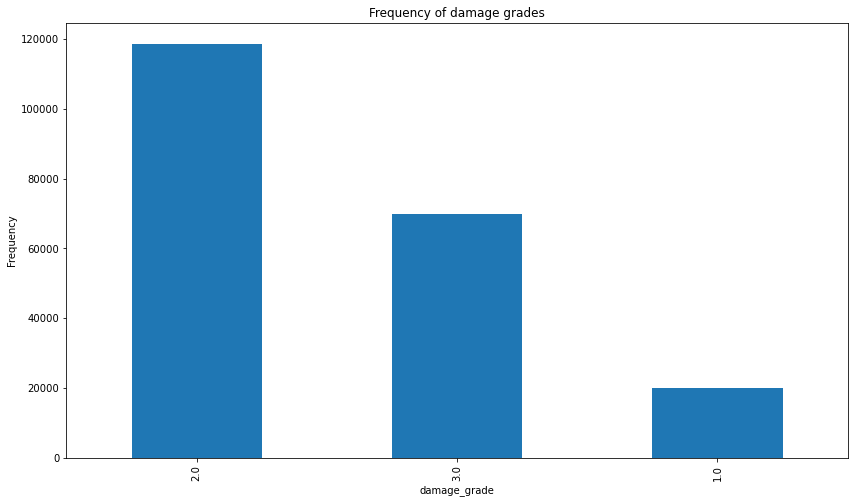

In [17]:
# investigate distribution of target variable
ax = target_train.value_counts().plot(kind='bar', figsize=(14,8), title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

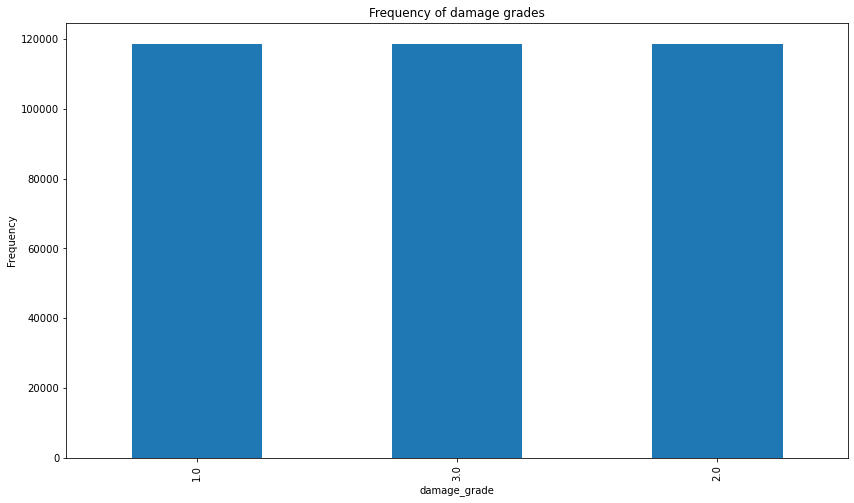

In [18]:
# choose to randomly oversample the train dataset as class 2 is highly over represented for our target variable damage grade
sampler = RandomOverSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

ax = train_balanced_target.value_counts().plot(kind='bar', figsize=(14,8), title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

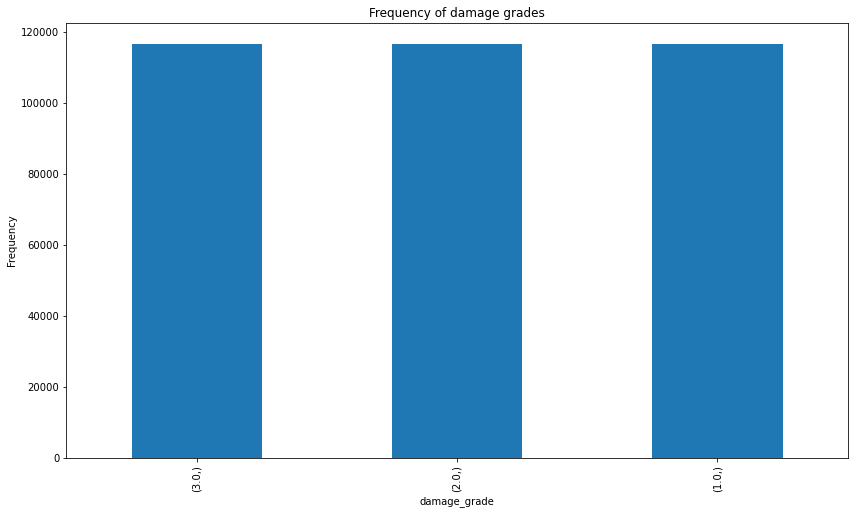

In [19]:
# choose to randomly oversample the outlier-train dataset as class 2 is highly over represented for our target variable damage grade
sampler = RandomOverSampler()
train_balanced_data_outlier, train_balanced_target_outlier = sampler.fit_resample(data_train_outlier, target_train_outlier)

ax = train_balanced_target_outlier.value_counts().plot(kind='bar', figsize=(14,8), title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

In [20]:
train_balanced_data

geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
0             0.700000        0.655221        0.474656                0.250   
1             0.100000        0.861247        0.087451                0.125   
2             0.700000        0.854240        0.215246                0.250   
3             0.666667        0.110722        0.195114                0.125   
4             0.300000        0.469516        0.475611                0.125   
...                ...             ...             ...                  ...   
355816        0.266667        0.998598        0.300151                0.125   
355817        0.233333        0.007008        0.366436                0.125   
355818        0.900000        0.809390        0.624731                0.125   
355819        0.900000        0.151367        0.319965                0.375   
355820        0.400000        0.986685        0.316305                0.125   

             age  area_percentage  height_percentage  \
0       0.020101         0.050505           0.133333   
1       0.020101         0.050505           0.100000   
2       0.045226         0.050505           0.100000   
3       0.010050         0.060606           0.100000   
4       0.000000         0.080808           0.133333   
...          ...              ...                ...   
355816  0.025126         0.121212           0.100000   
355817  0.015075         0.030303           0.133333   
355818  0.030151         0.090909           0.133333   
355819  0.010050         0.242424           0.266667   
355820  0.010050         0.040404           0.133333   

        has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                                  0                                    1   
1                                  1                                    1   
2                                  0                                    1   
3                                  0                                    0   
4                                  0                                    0   
...                              ...                                  ...   
355816                             0                                    1   
355817                             0                                    1   
355818                             0                                    1   
355819                             0                                    0   
355820                             0                                    1   

        has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   
...                               ...                                     ...   
355816                              0                                       0   
355817                              0                                       0   
355818                              1                                       0   
355819                              0                                       0   
355820                              0                                       0   

        has_superstructure_mud_mortar_brick  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
355816                                    0   
355817                                    0   
355818                                    0   
355819            

In [21]:
train_balanced_data_outlier

geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
0             0.533333        0.162579        0.083791                0.250   
1             0.700000        0.451997        0.332776                0.250   
2             0.566667        0.184303        0.636349                0.000   
3             0.366667        0.773651        0.183417                0.000   
4             0.700000        0.854240        0.215246                0.250   
...                ...             ...             ...                  ...   
349819        0.700000        0.235459        0.546829                0.125   
349820        0.266667        0.393132        0.843638                0.125   
349821        0.133333        0.389629        0.483011                0.125   
349822        0.200000        0.278907        0.683775                0.125   
349823        0.366667        0.536090        0.536087                0.375   

             age  area_percentage  height_percentage  \
0       0.010050         0.050505           0.100000   
1       0.020101         0.101010           0.166667   
2       0.005025         0.040404           0.000000   
3       0.020101         0.060606           0.033333   
4       0.040201         0.020202           0.100000   
...          ...              ...                ...   
349819  0.025126         0.101010           0.100000   
349820  0.005025         0.070707           0.133333   
349821  0.020101         0.040404           0.133333   
349822  0.005025         0.020202           0.100000   
349823  0.060302         0.070707           0.200000   

        has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                                  0                                    1   
1                                  0                                    1   
2                                  0                                    1   
3                                  0                                    1   
4                                  0                                    1   
...                              ...                                  ...   
349819                             0                                    1   
349820                             0                                    1   
349821                             0                                    1   
349822                             0                                    1   
349823                             0                                    0   

        has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   
...                               ...                                     ...   
349819                              0                                       0   
349820                              0                                       0   
349821                              0                                       0   
349822                              0                                       0   
349823                              0                                       0   

        has_superstructure_mud_mortar_brick  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
349819                                    0   
349820                                    0   
349821                                    0   
349822            

# Baseline model majority class

#### As a first baseline we will use a prediction model, that will just predict the majority class for all our targets in the validation set. Since we know that 148.259/260.601= 56,89% of our houses have damage_grade 2, all our targets will get label 2.

In [22]:
prediction = np.zeros((len(target_test), 1))+2
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.5689
The F1-Score micro on test set: 0.5689
The F1-Score macro on test set: 0.2417
Confusion Matrix : 
[[    0  5025     0]
 [    0 29652     0]
 [    0 17444     0]]


#### As expected the majority class vote has a not so bad f1_micro score and a worse f1_macro, since we only predict class 2.

# Decision Tree

### without Rebalance original train set

In [23]:
dt = DecisionTreeClassifier()
cross_val=cross_val_score(dt, data_train, target_train, cv=5, scoring='f1_micro')
dt.fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("Decision Trees CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

Decision Trees CV-average F1-score: 0.6514
The Accuracy on test set: 0.6573
The F1-Score micro on test set: 0.6573
The F1-Score macro on test set: 0.6073
Confusion Matrix : 
[[ 2553  2145   327]
 [ 2369 20916  6367]
 [  366  6287 10791]]


### with Rebalance original train set

In [24]:
dt = DecisionTreeClassifier()
dt.fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6600
The F1-Score micro on test set: 0.6600
The F1-Score macro on test set: 0.6089
Confusion Matrix : 
[[ 2510  2174   341]
 [ 2306 20992  6354]
 [  336  6208 10900]]


### without Rebalance and (no-) outlier training set

In [26]:
dt = DecisionTreeClassifier()
cross_val=cross_val_score(dt, data_train_outlier, target_train_outlier, cv=5, scoring='f1_micro')
dt.fit(data_train_outlier,target_train_outlier)
prediction = dt.predict(data_test_outlier)
acc = accuracy_score(target_test_outlier,prediction) 
f1_mic= f1_score(target_test_outlier,prediction,average='micro') 
f1_mac= f1_score(target_test_outlier,prediction,average='macro') 
print("Decision Trees CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test_outlier,prediction)))

Decision Trees CV-average F1-score: 0.6529
The Accuracy on test set: 0.6578
The F1-Score micro on test set: 0.6578
The F1-Score macro on test set: 0.6097
Confusion Matrix : 
[[ 2567  2057   323]
 [ 2328 20613  6211]
 [  350  6270 10537]]


### with Rebalance and (no-) outlier training set

In [27]:
dt = DecisionTreeClassifier()
dt.fit(train_balanced_data_outlier,train_balanced_target_outlier)
prediction = dt.predict(data_test_outlier)
acc = accuracy_score(target_test_outlier,prediction) 
f1_mic= f1_score(target_test_outlier,prediction,average='micro') 
f1_mac= f1_score(target_test_outlier,prediction,average='macro') 
print("Decision Trees CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test_outlier,prediction)))

Decision Trees CV-average F1-score: 0.6529
The Accuracy on test set: 0.6577
The F1-Score micro on test set: 0.6577
The F1-Score macro on test set: 0.6087
Confusion Matrix : 
[[ 2519  2103   325]
 [ 2224 20615  6313]
 [  374  6204 10579]]


# Logistic Regression

### ohne Rebalance

In [28]:
lr = LogisticRegression(max_iter=10000)
cross_val=cross_val_score(lr, data_train, target_train, cv=5, scoring='f1_micro')
lr.fit(data_train,target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("Logistic Regression CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

Logistic Regression CV-average F1-score: 0.5921
The Accuracy on test set: 0.5918
The F1-Score micro on test set: 0.5918
The F1-Score macro on test set: 0.4625
Confusion Matrix : 
[[ 1463  3447   115]
 [ 1044 25912  2696]
 [   88 13886  3470]]


### mit Rebalance

In [29]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.5074
The F1-Score micro on test set: 0.5074
The F1-Score macro on test set: 0.5045
Confusion Matrix : 
[[ 3460   729   836]
 [ 4775 11041 13836]
 [  779  4722 11943]]


### without Rebalance and (no-) outlier training set

In [30]:
lr = LogisticRegression(max_iter=10000)
cross_val=cross_val_score(lr, data_train_outlier, target_train_outlier, cv=5, scoring='f1_micro')
lr.fit(data_train_outlier,target_train_outlier)
prediction = lr.predict(data_test_outlier)
acc = accuracy_score(target_test_outlier,prediction) 
f1_mic= f1_score(target_test_outlier,prediction,average='micro') 
f1_mac= f1_score(target_test_outlier,prediction,average='macro') 
print("Logistic Regression CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test_outlier,prediction)))

/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Logistic Regression CV-average F1-score: 0.5916
The Accuracy on test set: 0.5925
The F1-Score micro on test set: 0.5925
The F1-Score macro on test set: 0.4656
Confusion Matrix : 
[[ 1494  3330   123]
 [ 1031 25495  2626]
 [   98 13677  3382]]


### with Rebalance and (no-) outlier training set

In [31]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_balanced_data_outlier,train_balanced_target_outlier)
prediction = lr.predict(data_test_outlier)
acc = accuracy_score(target_test_outlier,prediction) 
f1_mic= f1_score(target_test_outlier,prediction,average='micro') 
f1_mac= f1_score(target_test_outlier,prediction,average='macro') 
print("Logistic Regression CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test_outlier,prediction)))

/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Logistic Regression CV-average F1-score: 0.5916
The Accuracy on test set: 0.5058
The F1-Score micro on test set: 0.5058
The F1-Score macro on test set: 0.5001
Confusion Matrix : 
[[ 3286   739   922]
 [ 4741 10932 13479]
 [  758  4691 11708]]


# Naive Bayes

### ohne Rebalance

In [32]:
nb=GaussianNB()
cross_val=cross_val_score(nb, data_train, target_train, cv=5, scoring='f1_micro')
nb.fit(data_train,target_train)
prediction = nb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("Naive Bayes CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

Naive Bayes CV-average F1-score: 0.4189
The Accuracy on test set: 0.4200
The F1-Score micro on test set: 0.4200
The F1-Score macro on test set: 0.3989
Confusion Matrix : 
[[ 2940   584  1501]
 [ 4307  3486 21859]
 [  889  1089 15466]]


### mit Rebalance

In [33]:
nb=GaussianNB()
nb.fit(train_balanced_data, train_balanced_target)
prediction = nb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.4177
The F1-Score micro on test set: 0.4177
The F1-Score macro on test set: 0.3951
Confusion Matrix : 
[[ 3010   516  1499]
 [ 4521  3238 21893]
 [  935   984 15525]]


### without Rebalance and (no-) outlier training set

In [34]:
nb=GaussianNB()
cross_val=cross_val_score(nb, data_train_outlier, target_train_outlier, cv=5, scoring='f1_micro')
nb.fit(data_train_outlier,target_train_outlier)
prediction = nb.predict(data_test_outlier)
acc = accuracy_score(target_test_outlier,prediction) 
f1_mic= f1_score(target_test_outlier,prediction,average='micro') 
f1_mac= f1_score(target_test_outlier,prediction,average='macro') 
print("Naive Bayes CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test_outlier,prediction)))

/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Naive Bayes CV-average F1-score: 0.4192
The Accuracy on test set: 0.4194
The F1-Score micro on test set: 0.4194
The F1-Score macro on test set: 0.3967
Confusion Matrix : 
[[ 2870   516  1561]
 [ 4347  3402 21403]
 [  864  1069 15224]]


# KNN

### without Rebalance

In [35]:
knn=KNeighborsClassifier()
cross_val=cross_val_score(knn, data_train, target_train, cv=5, scoring='f1_micro')
knn.fit(data_train,target_train)
prediction = knn.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("KNN CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

KNN CV-average F1-score: 0.6624
The Accuracy on test set: 0.6697
The F1-Score micro on test set: 0.6697
The F1-Score macro on test set: 0.6103
Confusion Matrix : 
[[ 2377  2444   204]
 [ 1942 22493  5217]
 [  325  7086 10033]]


### with Rebalance

In [36]:
knn=KNeighborsClassifier()
knn.fit(train_balanced_data, train_balanced_target)
prediction = knn.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6119
The F1-Score micro on test set: 0.6119
The F1-Score macro on test set: 0.5847
Confusion Matrix : 
[[ 3602  1077   346]
 [ 5028 16509  8115]
 [  947  4716 11781]]


### without Rebalance and (no-) outlier training set

In [37]:
knn=KNeighborsClassifier()
cross_val=cross_val_score(knn, data_train_outlier, target_train_outlier, cv=5, scoring='f1_micro')
knn.fit(data_train_outlier,target_train_outlier)
prediction = knn.predict(data_test_outlier)
acc = accuracy_score(target_test_outlier,prediction) 
f1_mic= f1_score(target_test_outlier,prediction,average='micro') 
f1_mac= f1_score(target_test_outlier,prediction,average='macro') 
print("KNN CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test_outlier,prediction)))

/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was

KNN CV-average F1-score: 0.6617
The Accuracy on test set: 0.6675
The F1-Score micro on test set: 0.6675
The F1-Score macro on test set: 0.6064
Confusion Matrix : 
[[ 2308  2419   220]
 [ 1944 22143  5065]
 [  328  7069  9760]]


# MLP Classifier

### without Rebalance

In [58]:
mlp=MLPClassifier()
cross_val=cross_val_score(mlp, data_train, target_train, cv=5, scoring='f1_micro')
mlp.fit(data_train,target_train)
prediction = mlp.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("MLP CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP CV-average F1-score: 0.6603
The Accuracy on test set: 0.6673
The F1-Score micro on test set: 0.6673
The F1-Score macro on test set: 0.5950
Confusion Matrix : 
[[ 2021  2895   109]
 [ 1162 24356  4134]
 [  101  8938  8405]]


### with Rebalance

In [59]:
mlp=MLPClassifier()
mlp.fit(train_balanced_data, train_balanced_target)
prediction = mlp.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The Accuracy on test set: 0.5553
The F1-Score micro on test set: 0.5553
The F1-Score macro on test set: 0.5375
Confusion Matrix : 
[[ 4179   627   219]
 [ 7947 13279  8426]
 [ 1518  4440 11486]]


### without Rebalance and (no-) outlier training set

In [60]:
mlp=MLPClassifier()
cross_val=cross_val_score(mlp, data_train_outlier, target_train_outlier, cv=5, scoring='f1_micro')
mlp.fit(data_train_outlier,target_train_outlier)
prediction = mlp.predict(data_test_outlier)
acc = accuracy_score(target_test_outlier,prediction) 
f1_mic= f1_score(target_test_outlier,prediction,average='micro') 
f1_mac= f1_score(target_test_outlier,prediction,average='macro') 
print("MLP CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test_outlier,prediction)))

/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached an

MLP CV-average F1-score: 0.6587
The Accuracy on test set: 0.6561
The F1-Score micro on test set: 0.6561
The F1-Score macro on test set: 0.6002
Confusion Matrix : 
[[ 2079  2624   244]
 [ 1323 21436  6393]
 [  116  6928 10113]]


# Random Forest

### without Rebalance

In [47]:
rf = RandomForestClassifier()
cross_val=cross_val_score(rf, data_train, target_train, cv=5,scoring='f1_micro')
rf.fit(data_train, target_train)
prediction = rf.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("Random Forest CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

Random Forest CV-average F1-score: 0.7127
The Accuracy on test set: 0.7183
The F1-Score micro on test set: 0.7183
The F1-Score macro on test set: 0.6599
Confusion Matrix : 
[[ 2415  2511    99]
 [ 1232 24479  3941]
 [  125  6773 10546]]


### with Rebalance

In [48]:
rf = RandomForestClassifier()
rf.fit(train_balanced_data, train_balanced_target)
prediction = rf.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.7061
The F1-Score micro on test set: 0.7061
The F1-Score macro on test set: 0.6646
Confusion Matrix : 
[[ 2953  1943   129]
 [ 1991 22680  4981]
 [  222  6054 11168]]


### without Rebalance and (no-) outlier training set

In [49]:
rf = RandomForestClassifier()
cross_val=cross_val_score(rf, data_train_outlier, target_train_outlier, cv=5,scoring='f1_micro')
rf.fit(data_train_outlier, target_train_outlier)
prediction = rf.predict(data_test_outlier)
acc = accuracy_score(target_test_outlier,prediction) 
f1_mic= f1_score(target_test_outlier,prediction,average='micro') 
f1_mac= f1_score(target_test_outlier,prediction,average='macro') 
print("Random Forest CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test_outlier,prediction)))

/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jenniferhahn/opt/anaconda3/lib/python3.8/site-packages/sklearn/mod

Random Forest CV-average F1-score: 0.7126
The Accuracy on test set: 0.7167
The F1-Score micro on test set: 0.7167
The F1-Score macro on test set: 0.6579
Confusion Matrix : 
[[ 2356  2464   127]
 [ 1151 24120  3881]
 [  126  6773 10258]]


# XGBoost

### ohne Rebalance

In [ ]:
xgb = XGBClassifier()
cross_val=cross_val_score(xgb, data_train, target_train, cv=5, scoring='f1_micro')
xgb.fit(data_train, target_train)
prediction = xgb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("XGBoost CV-average F1-score: %.4f" % cross_val.mean())
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

### mit Rebalance

In [ ]:
xgb = XGBClassifier()
xgb.fit(train_balanced_data, train_balanced_target)
prediction = xgb.predict(data_test)
xgb = xgb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

### without Rebalance and (no-) outlier training set

## --> Result: Performance is better without balancing and not using the dataset that has any outliers removed! We will continue without it

## We will now focus on KNN, Random Forest and XGBoost to add additional features and get a deep-dive in the next notebook.